In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers

In [2]:
# Seaborn dataset of two columns, a date and the value of the sea ice

df = sns.load_dataset('seaice').dropna()

In [3]:
# The date is not relevent as we want to capture the behavior relative to previous days, not days as a group

data = df['Extent']
# Capture the previous behavior of 24 hours 
window = 24
# Predict only 1 day in the future
future = 1

X, y = [], []

for i in range(window, len(data) - future + 1):
    X.append([[a] for a in data[i-window:i]])
    y.append(data[i])

X, y = np.array(X), np.array(y)

# Predict the last 20% using 80% to train
split = int(data.shape[0] * .8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [4]:
# Create and compile the model with summary
model = tf.keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2], )))
model.add(layers.LSTM(units=64, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(units=1, activation='linear'))

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=.001), metrics=['mse'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Fit the model

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    validation_split=.2,
                    batch_size=32,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True),
                    verbose=0,
                   )

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1960 - mse: 0.1960
Loss: 0.24573591351509094


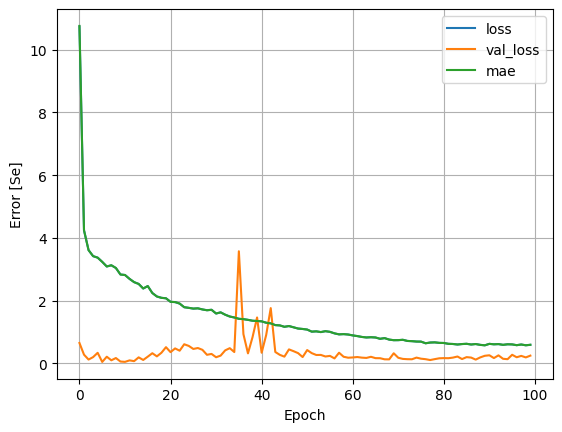

In [6]:
# Observe loss and error

loss, acc = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['mse'], label='mae')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Se]')
    plt.legend()
    plt.grid(True)

hist = pd.DataFrame(history.history)
plot_loss(history)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


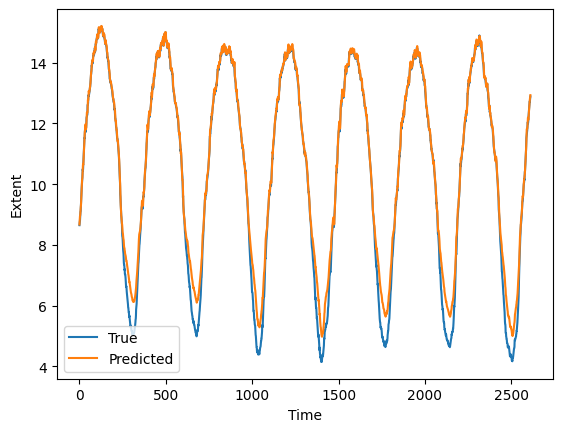

In [7]:
# Compare the predicted to actual data

y_pred = model.predict(X_test)
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Extent')
plt.legend()
plt.show()